# Gemini guidelines
Notebook to get guidelines for Gemini plot, namely
- best bid/ask for all times
- last trade price for all times

In the process, will also probably calculate the data required for cumulative interest chart

In [18]:
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [20]:
%matplotlib inline

Read in interest changes

In [2]:
interest = pd.read_json("./gemini_interest.json")

In [3]:
interest.head()

,fixed_timestampms,next_tim,price_padded,remaining,side
0,1547662175932,1.547662e+12,3614.45,0.0000,bid
1,1547662176331,1.547662e+12,3615.56,0.0800,bid
2,1547662176470,1.547662e+12,3613.42,0.5400,bid
3,1547662176546,NaN,3619.86,0.0000,bid
4,1547662176563,1.547662e+12,3619.54,6.8651,bid


In [4]:
interest.dtypes

fixed_timestampms      int64
next_tim             float64
price_padded         float64
remaining            float64
side                  object
dtype: object

In [5]:
len(interest)

6736

In [6]:
all_times = interest[["fixed_timestampms"]].drop_duplicates()

In [7]:
pos_interest = interest[interest.remaining > 0]

In [8]:
len(pos_interest) * len(all_times)

25107490

Join runs out of memory

In [13]:
all_times["dummy"] = 1
pos_interest["dummy"] = 1
interest_join = all_times.merge(
    right = pos_interest.rename(
        columns = {i: i + "_pi" for i in pos_interest.columns if i != "dummy"}),
    on = ["dummy"],
    how = "left")

/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


MemoryError: 

Trying a loop approach

In [9]:
all_rel_events = []
for ts in tqdm(all_times.fixed_timestampms):
    rel_events = pos_interest[(pos_interest.fixed_timestampms <= ts) & (pos_interest.next_tim >= ts)]
    rel_events["ref_tim"] = ts
    all_rel_events += [rel_events]

  0%|          | 0/6310 [00:00<?, ?it/s]/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
100%|██████████| 6310/6310 [09:04<00:00, 11.58it/s]


In [10]:
rel_events_df =pd.concat(all_rel_events)

In [11]:
len(rel_events_df)

140045

In [16]:
inside = rel_events_df.groupby(["ref_tim", "side"], as_index = False)["price_padded"].agg([min, max]).reset_index()

In [17]:
inside.head()

,ref_tim,side,min,max
0,1547662175932,ask,3621.92,3622.95
1,1547662175932,bid,3613.42,3620.42
2,1547662176331,ask,3621.92,3622.95
3,1547662176331,bid,3613.42,3620.42
4,1547662176470,ask,3621.92,3622.95


In [27]:
type(inside[inside.side == "ask"]["min"].values[0])

numpy.float64

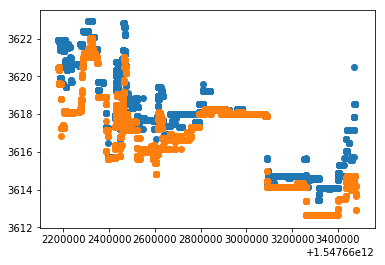

In [33]:
plt.scatter(x = inside[inside.side == "ask"].ref_tim.values, y = inside[inside.side == "ask"]["min"].values)
plt.scatter(x = inside[inside.side == "bid"].ref_tim.values, y = inside[inside.side == "bid"]["max"].values)

In [35]:
inside["inside"] = inside.apply(lambda x: x["min"] if x["side"] == "ask" else x["max"], axis = 1)

In [51]:
inside["inside_padded"] = inside.inside.astype("str").str.pad(7, "left", "0")

In [53]:
inside[["ref_tim", "side", "inside_padded"]].to_json("./gemini_inside.json", orient = "records")

In [39]:
rel_events_df.to_csv("./gemini_rel_events.csv")

Events at the same time?

In [42]:
num_events = interest.groupby(["fixed_timestampms", "price_padded", "side"], as_index = False).count()

In [45]:
num_events.sort_values("remaining", ascending = False).head()

,fixed_timestampms,price_padded,side,next_tim,remaining
1161,1547662325535,3622.02,bid,1,2
2295,1547662441712,3618.99,ask,2,2
1581,1547662372643,3618.93,ask,2,2
1373,1547662344796,3621.01,bid,2,2
3905,1547662689404,3616.64,bid,2,2
